In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import warnings
from datetime import datetime
from math import sqrt
from matplotlib.pylab import rcParams
from numpy.linalg import LinAlgError
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller, pacf

rcParams['figure.figsize'] = 15, 6

In [3]:
def test_stationarity(timeseries, period):
    
    rolmean = pd.Series(timeseries).rolling(window=period).mean()
    rolstd = pd.Series(timeseries).rolling(window=period).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

Quarter
2021-09-30    13757.0
2021-12-31    17719.0
2022-03-31    18756.0
2022-06-30    16934.0
2022-09-30    21454.0
Name: Tesla Quarterly Revenue (Millions), dtype: float64


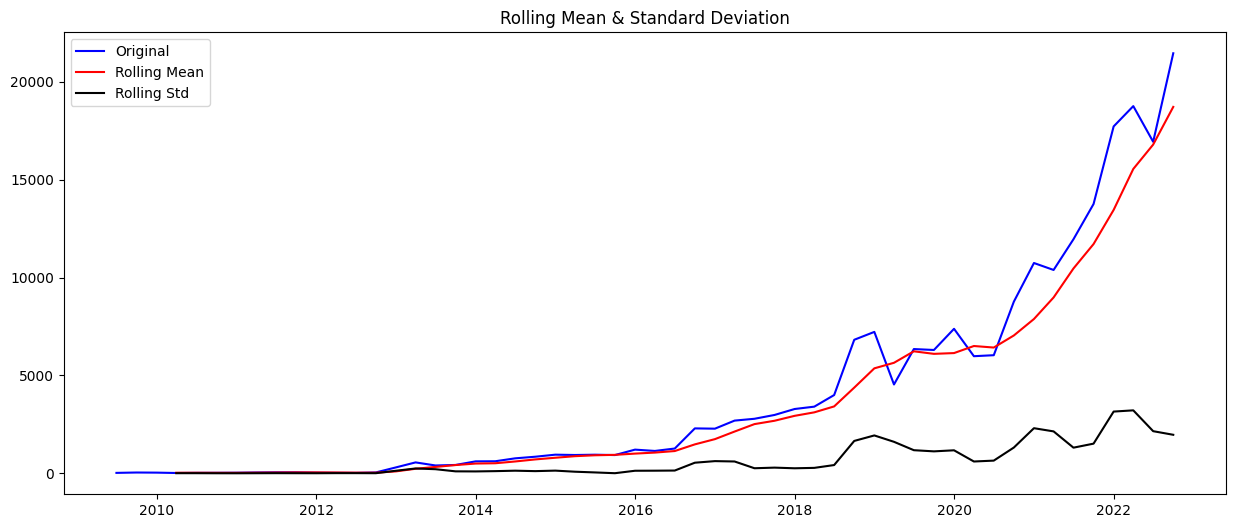

Results of Dickey-Fuller Test:
Test Statistic                  4.196921
p-value                         1.000000
#Lags Used                      7.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


In [4]:
dfq = pd.read_csv('./df_quarterly.csv', parse_dates=['Quarter'], index_col='Quarter')
dfq.drop(["Unnamed: 0"], axis=1, inplace=True)

tlq = dfq["Tesla Quarterly Revenue (Millions)"]
print(tlq.tail())
test_stationarity(tlq, 4)

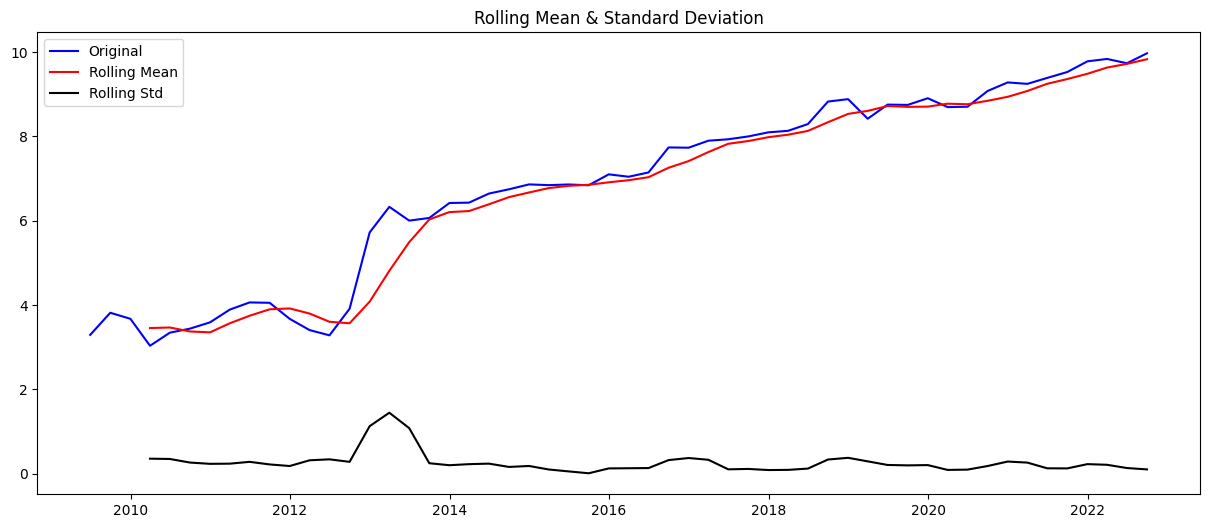

Results of Dickey-Fuller Test:
Test Statistic                 -0.732745
p-value                         0.838085
#Lags Used                      2.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


In [5]:
tlq_log = np.log(tlq)
test_stationarity(tlq_log, 4)

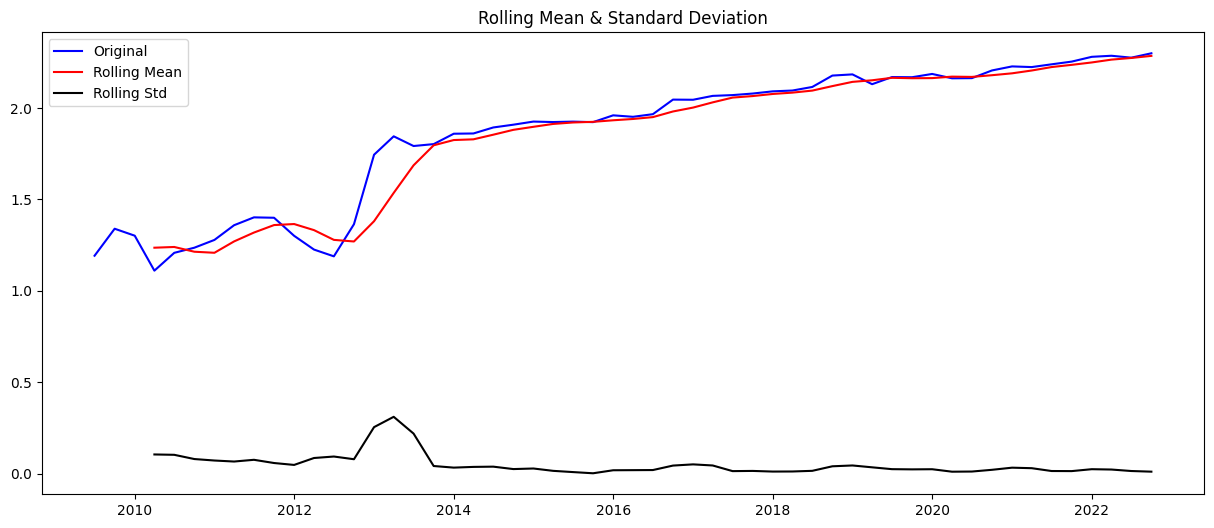

Results of Dickey-Fuller Test:
Test Statistic                 -1.295612
p-value                         0.631177
#Lags Used                      2.000000
Number of Observations Used    51.000000
Critical Value (1%)            -3.565624
Critical Value (5%)            -2.920142
Critical Value (10%)           -2.598015
dtype: float64


In [6]:
tlq_2log = np.log(tlq_log)
test_stationarity(tlq_2log, 4)

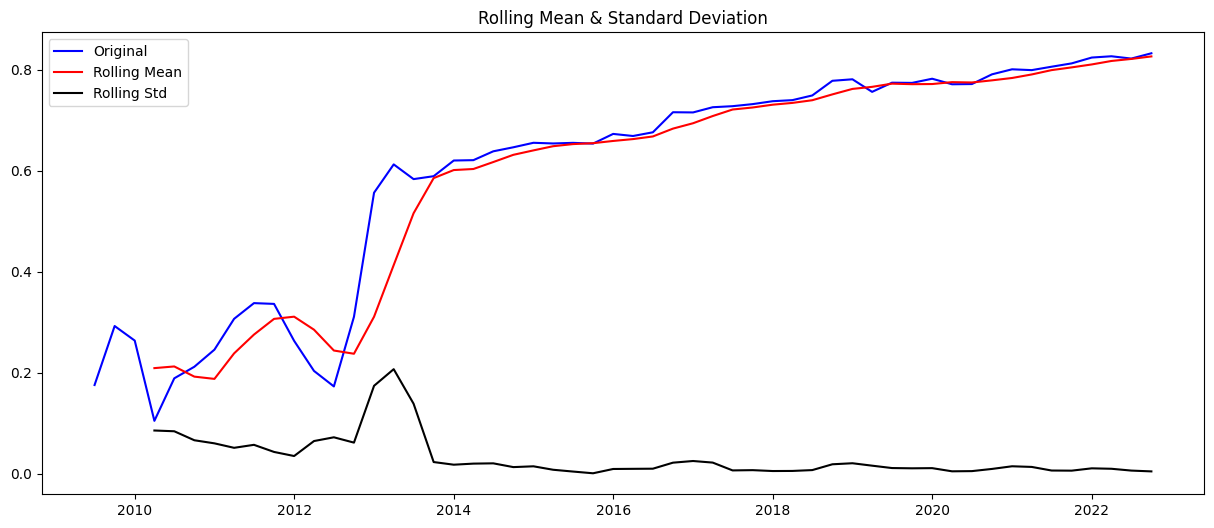

Results of Dickey-Fuller Test:
Test Statistic                 -5.223215
p-value                         0.000008
#Lags Used                     11.000000
Number of Observations Used    42.000000
Critical Value (1%)            -3.596636
Critical Value (5%)            -2.933297
Critical Value (10%)           -2.604991
dtype: float64


In [7]:
tlq_3log = np.log(tlq_2log)
test_stationarity(tlq_3log, 4)

Quarter
2010-03-31   -0.420264
2010-06-30   -0.122420
2010-09-30    0.066890
2010-12-31    0.237617
2011-03-31    0.324392
Name: Tesla Quarterly Revenue (Millions), dtype: float64

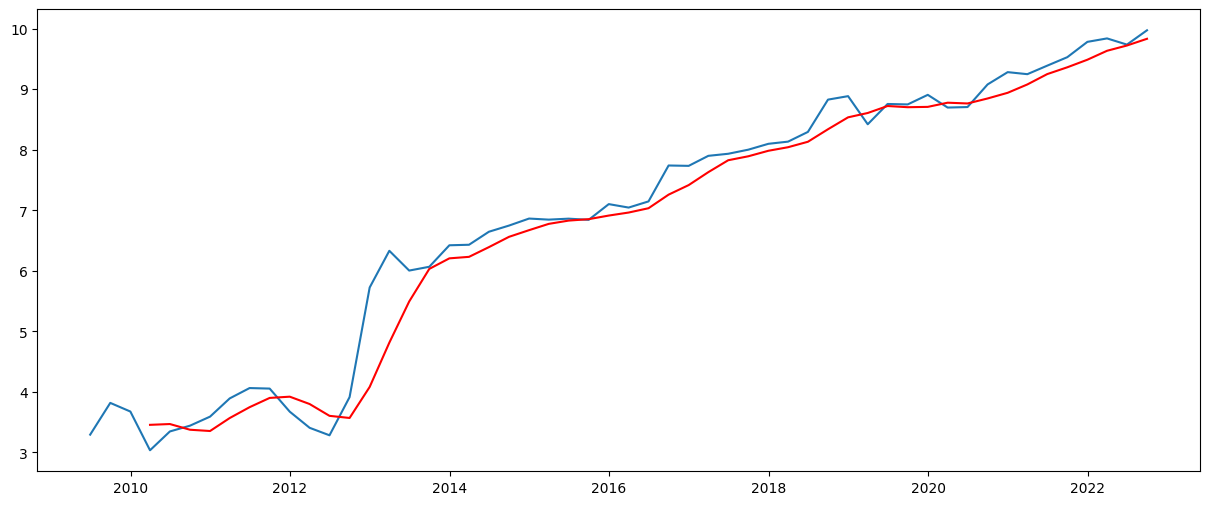

In [8]:
moving_avg = pd.Series(tlq_log).rolling(window=4).mean()
plt.plot(tlq_log)
plt.plot(moving_avg, color='red')

tlq_log_moving_avg_diff = tlq_log - moving_avg
tlq_log_moving_avg_diff.head(5)

tlq_log_moving_avg_diff.dropna(inplace=True)
tlq_log_moving_avg_diff.head(5)

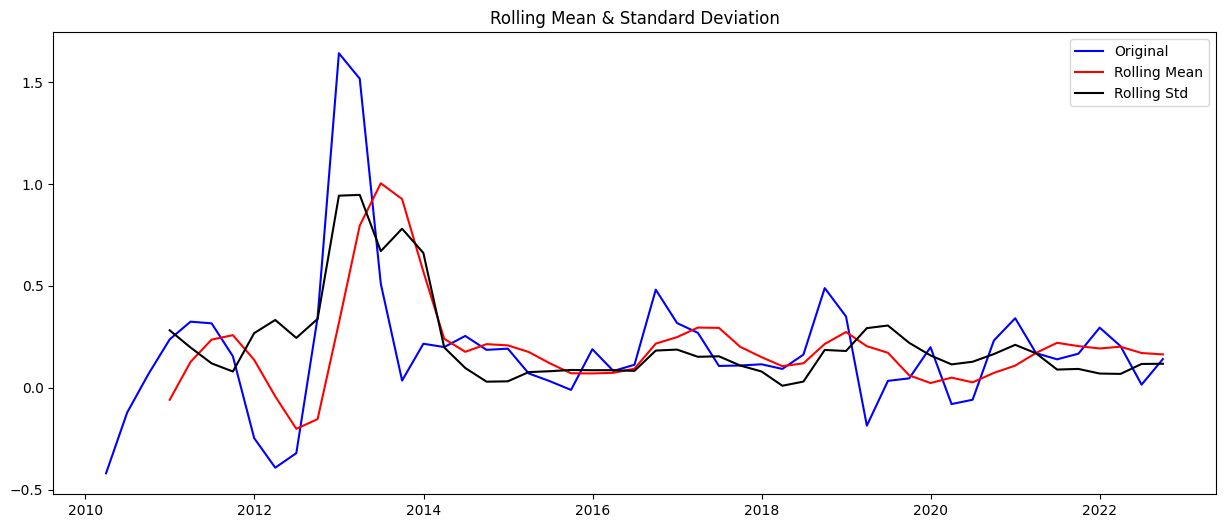

Results of Dickey-Fuller Test:
Test Statistic                 -4.156942
p-value                         0.000779
#Lags Used                      2.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [9]:
test_stationarity(tlq_log_moving_avg_diff, 4)

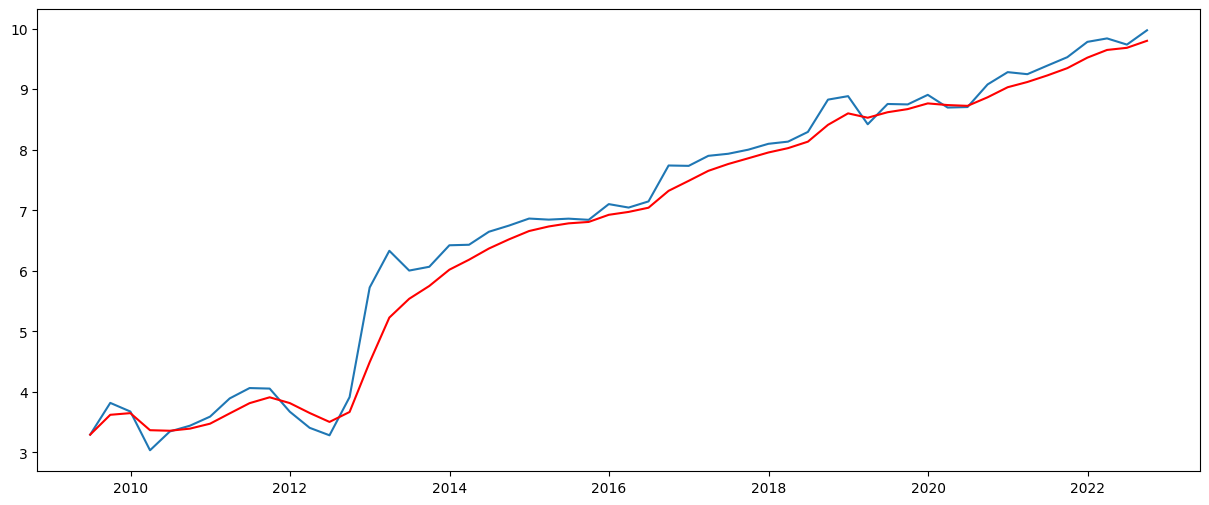

In [10]:
expwighted_avg = tlq_log.ewm(span=4).mean() 
plt.plot(tlq_log)
plt.plot(expwighted_avg, color='red')

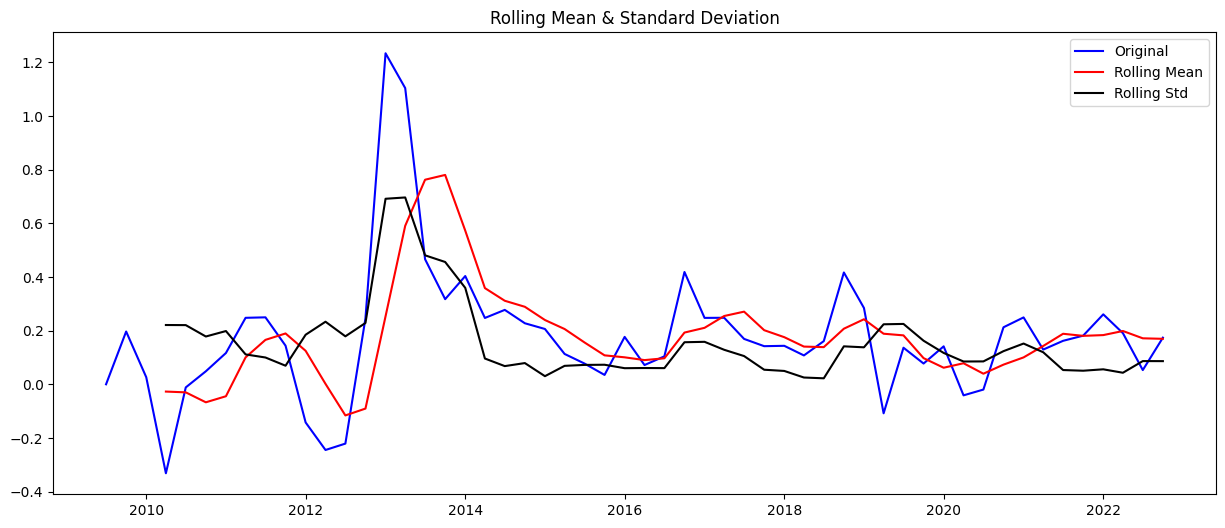

Results of Dickey-Fuller Test:
Test Statistic                 -4.824783
p-value                         0.000049
#Lags Used                      1.000000
Number of Observations Used    52.000000
Critical Value (1%)            -3.562879
Critical Value (5%)            -2.918973
Critical Value (10%)           -2.597393
dtype: float64


In [11]:
tlq_log_ewma_diff = tlq_log - expwighted_avg
test_stationarity(tlq_log_ewma_diff, 4)

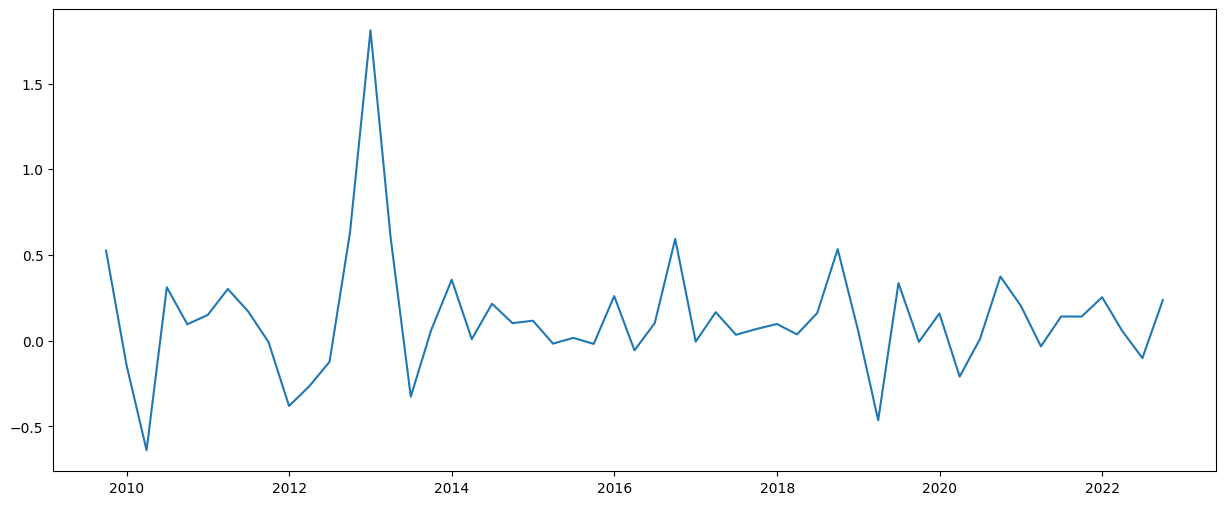

In [12]:
tlq_log_diff = tlq_log - tlq_log.shift()
plt.plot(tlq_log_diff)

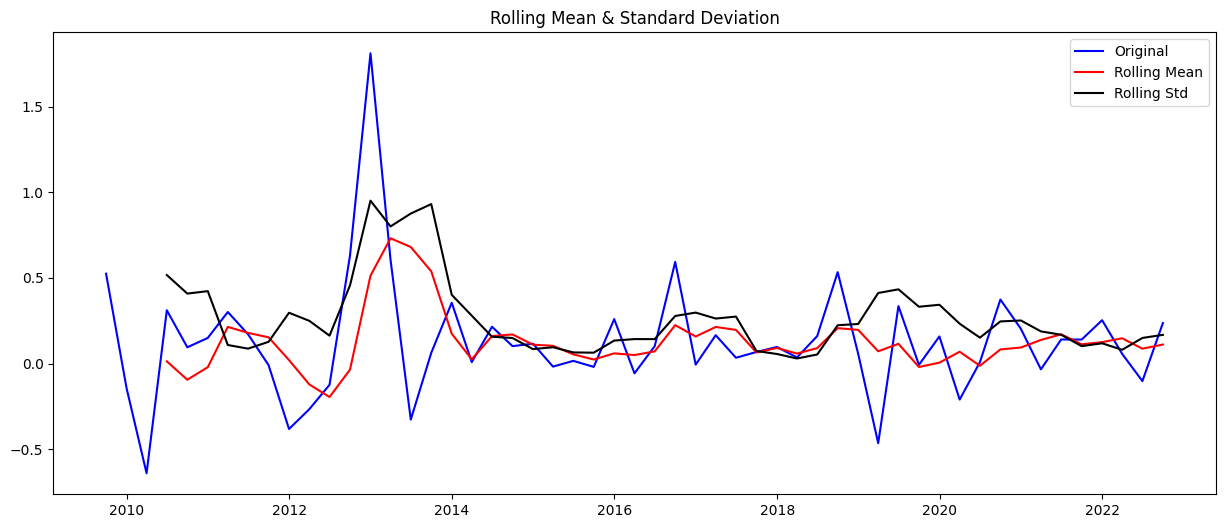

Results of Dickey-Fuller Test:
Test Statistic                -6.310605e+00
p-value                        3.241695e-08
#Lags Used                     1.000000e+00
Number of Observations Used    5.100000e+01
Critical Value (1%)           -3.565624e+00
Critical Value (5%)           -2.920142e+00
Critical Value (10%)          -2.598015e+00
dtype: float64


In [13]:
tlq_log_diff.dropna(inplace=True)
test_stationarity(tlq_log_diff, 4)

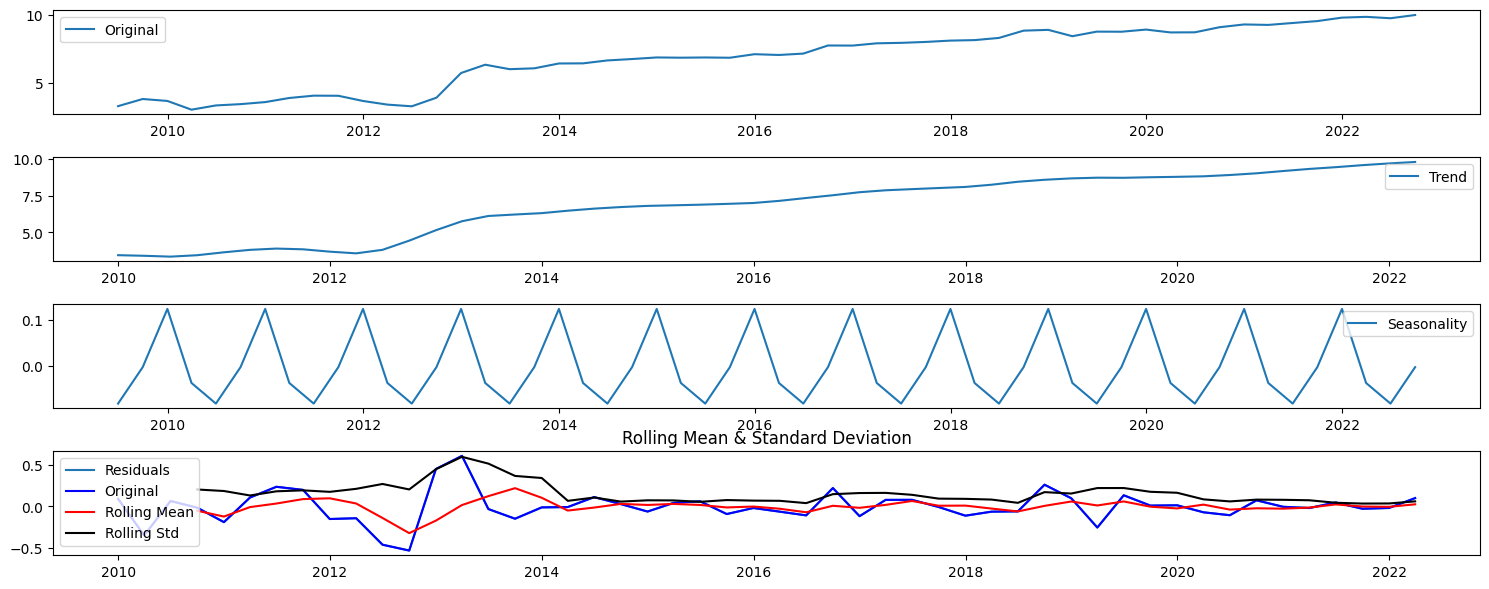

Results of Dickey-Fuller Test:
Test Statistic                -6.232664e+00
p-value                        4.910259e-08
#Lags Used                     1.100000e+01
Number of Observations Used    3.800000e+01
Critical Value (1%)           -3.615509e+00
Critical Value (5%)           -2.941262e+00
Critical Value (10%)          -2.609200e+00
dtype: float64


In [14]:
#DECOMPOSITION
decomposition = seasonal_decompose(tlq_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(tlq_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

tlq_log_decompose = residual
tlq_log_decompose.dropna(inplace=True)
test_stationarity(tlq_log_decompose, 4)

Text(0.5, 1.0, 'Autocorrelation Function')

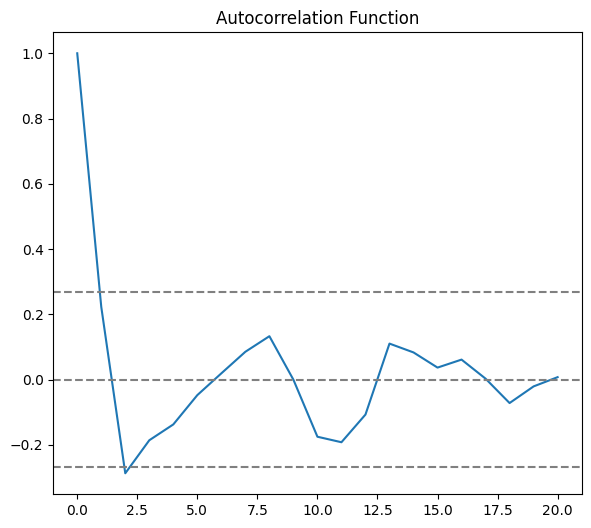

In [15]:


lag_acf = acf(tlq_log_diff, nlags=20)
lag_pacf = pacf(tlq_log_diff, nlags=20, method='ols')

#Plot ACF
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tlq_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tlq_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

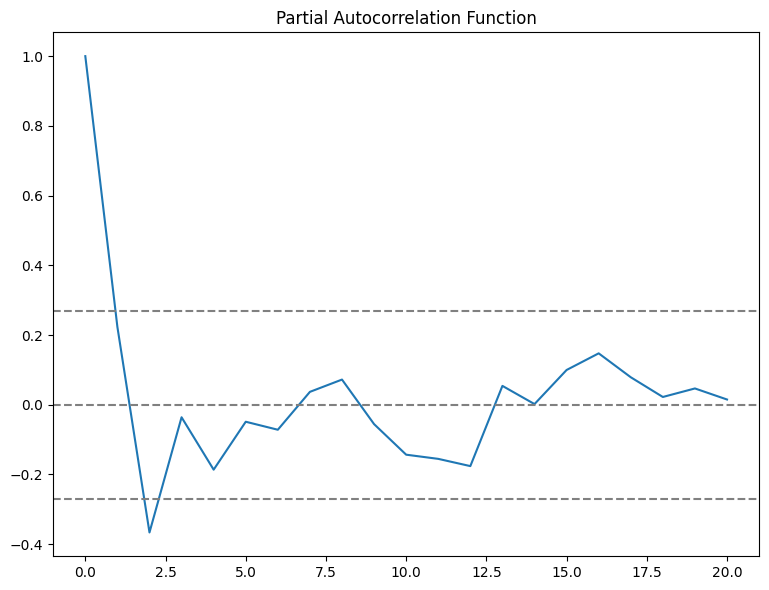

In [16]:
#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tlq_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tlq_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [17]:
tlq_values=tlq_log.values

X = tlq_values
size = int(len(X) * 0.85)
train, test = X[0:size], X[size:len(X)]

#AR Model
#training will be 11years, test will be 2years as per our model
warnings.filterwarnings("ignore")

history = [x for x in train]
predictions = list()
#test.reset_index()
for t in range(len(test)):
    try:
        model = ARIMA(history, order=(4,2,3))
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    except (ValueError, LinAlgError):
        pass
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
rmse = mean_squared_error(test, predictions)**0.5
print('Test MSE: %.3f' % rmse)

rms = sqrt(mean_squared_error(test, predictions))

predicted=9.001251, expected=9.079206
predicted=9.322417, expected=9.282103
predicted=9.283576, expected=9.248503
predicted=9.407198, expected=9.389156
predicted=9.496197, expected=9.529303
predicted=9.649500, expected=9.782393
predicted=10.044491, expected=9.839269
predicted=9.782613, expected=9.737079
predicted=9.879169, expected=9.973666
Test MSE: 0.095


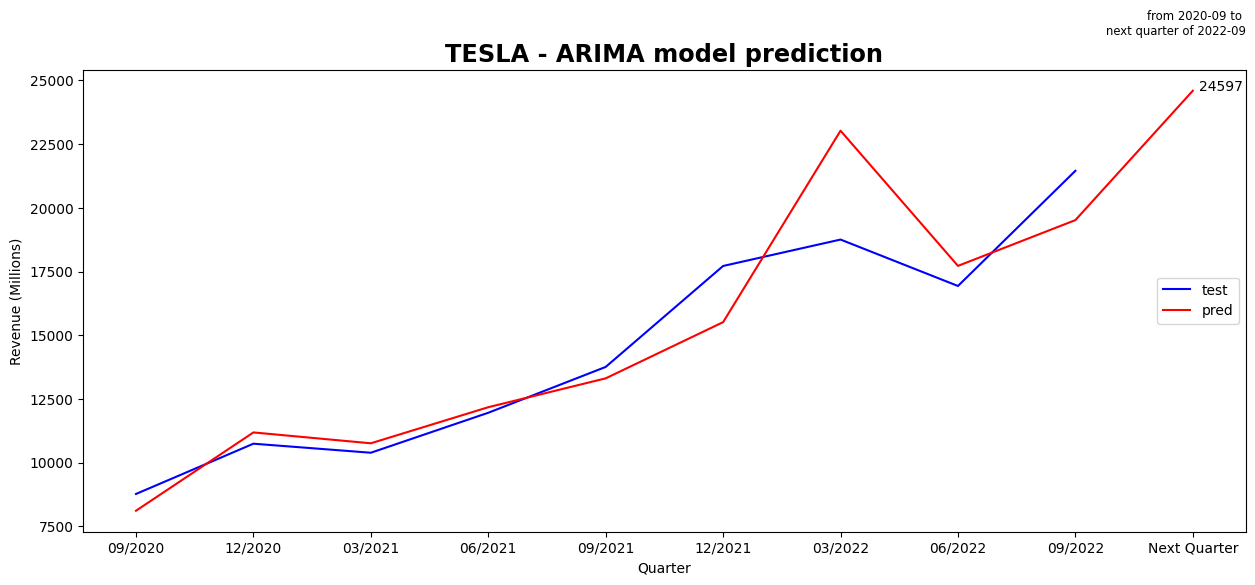

In [18]:
new_predictions = predictions.copy()
new_predictions.append(model_fit.forecast(steps=2)[1])
x = list(dfq.index[-9:].strftime("%m/%Y"))
x.append("Next Quarter")

plt.title("TESLA - ARIMA model prediction", fontdict={"fontsize": "xx-large", "fontweight": "bold"})
plt.suptitle(f'''from {dfq.index[-9:].strftime("%Y-%m")[0]} to \nnext quarter of {dfq.index[-9:].strftime("%Y-%m")[-1]}''', x= plt.xlim()[1]-0.1, horizontalalignment= "right", verticalalignment="top", fontsize="small")
plt.xlabel("Quarter")
plt.ylabel("Revenue (Millions)")
plt.xticks(range(len(x)), x)

plt.plot(np.exp(test), color = 'blue', label='test')
plt.plot(np.exp(new_predictions), color='red', label='pred')
plt.legend(loc = 'center right')
plt.subplot().text(plt.xlim()[1]-0.4, np.exp(new_predictions[-1]), int(np.exp(new_predictions[-1])))
plt.show()

In [19]:
rms = sqrt(mean_squared_error(np.exp(test), np.exp(predictions)))
print('Mean Squarred Error: %.2f'% rms)

Mean Squarred Error: 1779.36


In [20]:
#Auto ARIMA

arima_model = auto_arima(train, start_p=1, start_q=1, d=1, max_p=4, max_q=4, start_P=1, 
                         D=None, start_Q=1, max_P=4, max_D=1, max_Q=4, max_order=5, m=1, 
                         seasonal=True, stationary=False, information_criterion='aic', 
                         alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, 
                         n_jobs=1, start_params=None, trend=None, method='lbfgs', 
                         maxiter=50, offset_test_args=None, seasonal_test_args=None, 
                         suppress_warnings=True, error_action='trace', trace=False, 
                         random=False, random_state=None, n_fits=10, 
                         return_valid_fits=False, out_of_sample_size=0, 
                         scoring='mse', scoring_args=None, with_intercept='auto', 
                         sarimax_kwargs=None)

arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(0, 1, 2)   Log Likelihood                 -14.825
Date:                Tue, 15 Nov 2022   AIC                             37.650
Time:                        17:22:37   BIC                             44.787
Sample:                             0   HQIC                            40.297
                                 - 45                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1265      0.061      2.086      0.037       0.008       0.245
ma.L1          0.2657      0.206      1.292      0.196      -0.137       0.669
ma.L2         -0.3327      0.235     -1.414      0.157      -0.794       0.128
sigma2         0.1138      0.022      5.175      0.000       0.071       0.157
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                76.15
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.28   Skew:                             1.60
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

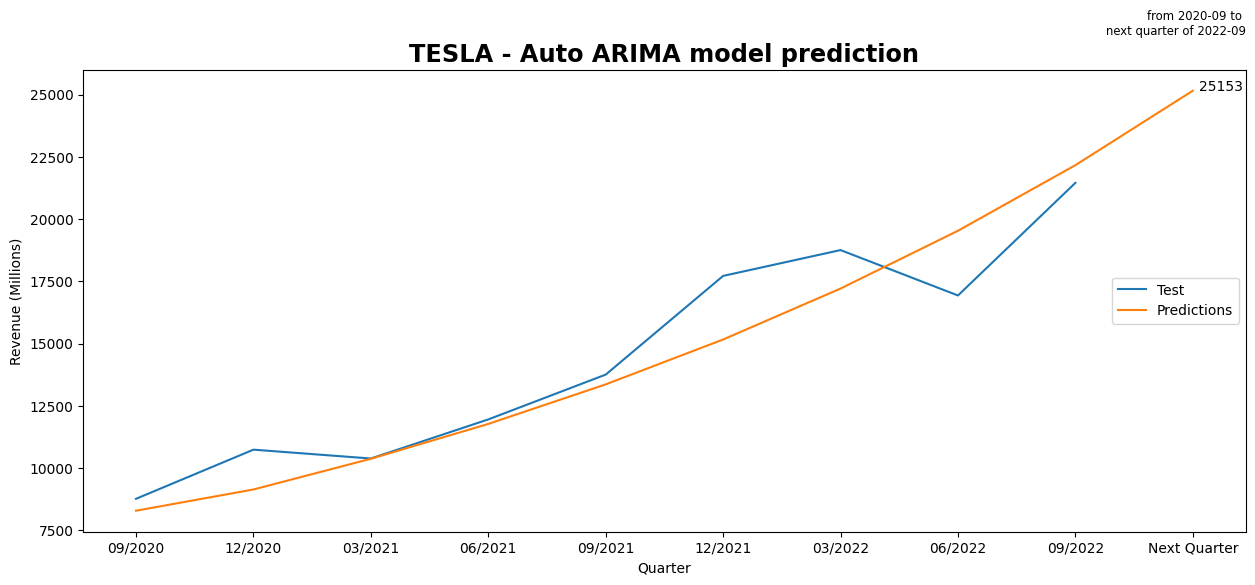

In [21]:
prediction_arima_model = arima_model.predict(n_periods=len(test)+1)

plt.title("TESLA - Auto ARIMA model prediction", fontdict={"fontsize": "xx-large", "fontweight": "bold"})
plt.suptitle(f'''from {dfq.index[-9:].strftime("%Y-%m")[0]} to \nnext quarter of {dfq.index[-9:].strftime("%Y-%m")[-1]}''', x= plt.xlim()[1]-0.1, horizontalalignment= "right", verticalalignment="top", fontsize="small")
plt.xlabel("Quarter")
plt.ylabel("Revenue (Millions)")
plt.xticks(range(len(x)), x)

plt.plot(np.exp(test), label='Test')
plt.plot(np.exp(prediction_arima_model), label='Predictions')
plt.legend(loc = 'center right')
plt.subplot().text(plt.xlim()[1]-0.4, np.exp(prediction_arima_model[-1]), int(np.exp(prediction_arima_model[-1])))
plt.show()

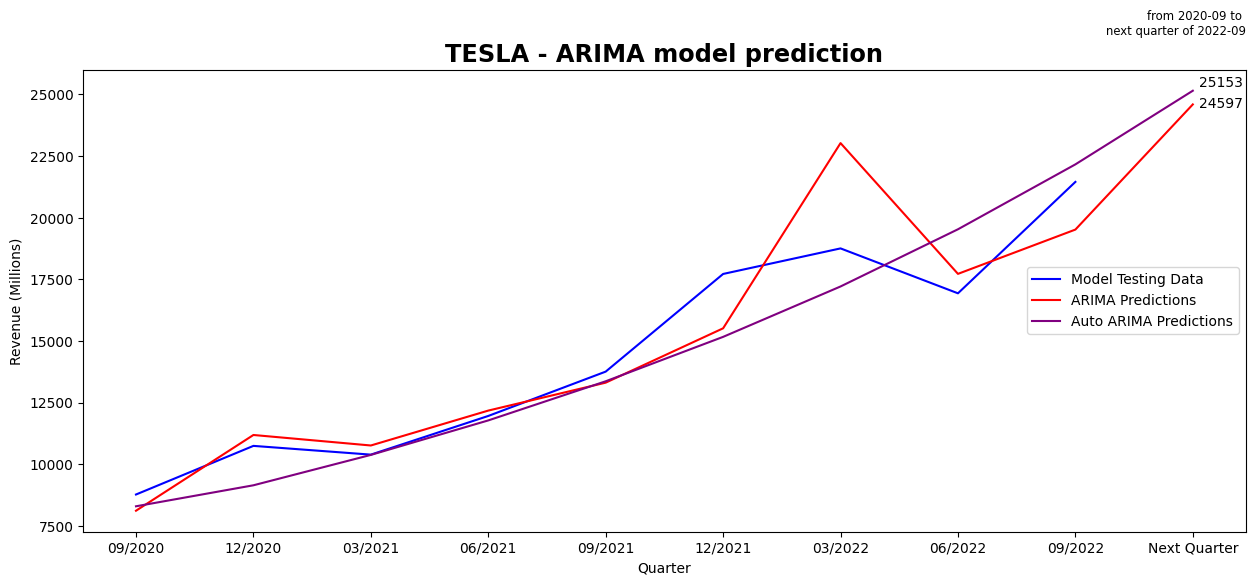

In [28]:
plt.title("TESLA - ARIMA model prediction", fontdict={"fontsize": "xx-large", "fontweight": "bold"})
plt.suptitle(f'''from {dfq.index[-9:].strftime("%Y-%m")[0]} to \nnext quarter of {dfq.index[-9:].strftime("%Y-%m")[-1]}''', x= plt.xlim()[1]-0.1, horizontalalignment= "right", verticalalignment="top", fontsize="small")
plt.xlabel("Quarter")
plt.ylabel("Revenue (Millions)")
plt.xticks(range(len(x)), x)

plt.plot(np.exp(test), color = 'blue', label='Model Testing Data')
plt.plot(np.exp(new_predictions), color='red', label='ARIMA Predictions')
plt.plot(np.exp(prediction_arima_model), color='purple', label='Auto ARIMA Predictions')
plt.legend(loc = 'center right')
plt.subplot().text(plt.xlim()[1]-0.4, np.exp(new_predictions[-1])-150, int(np.exp(new_predictions[-1])))
plt.subplot().text(plt.xlim()[1]-0.4, np.exp(prediction_arima_model[-1])+150, int(np.exp(prediction_arima_model[-1])))
plt.show()